In [1]:
import os

from matplotlib import pyplot as plt

from eda.eda_manager import EDAManager
from preprocess.preprocessors import PreprocessorManager

# Configuration

In [2]:
# 'audio' or 'vibe'
DATA_TYPE = 'audio'

DATASET_PATH = os.path.join('datasets', 'example', 'audio', 'acoustic_rpm_2000')

# Preprocess Data

In [3]:
preprocessor = PreprocessorManager(
    data_type=DATA_TYPE,
    dataset_root_path=DATASET_PATH,
    sample_rate=32000,
    n_mels=128,
    window_length=0.064,
    hop_length=0.032
)

preprocessor.save_config()

# run preprocessing
preprocessor.run_save()

prep_dest_path = preprocessor.dest_path

acoustic_rpm_2000: 100%|██████████| 400/400 [00:03<00:00, 123.00it/s]


In [4]:
preprocessor.config

{'data_type': 'audio',
 'sample_rate': 32000,
 'n_mels': 128,
 'window_length': 0.064,
 'hop_length': 0.032,
 'n_window': 2048,
 'n_hops': 1024,
 'dataset_root_path': 'datasets/example/audio/acoustic_rpm_2000',
 'dataset_name': 'acoustic_rpm_2000',
 'class_list': ['normal', 'abnormal'],
 'dest_path': '/home/joohyun/deep-model-zoo/datasets/preprocessed/acoustic_rpm_2000_1624414180',
 'train_split_ratio': 7,
 'test_split_ratio': 3,
 'num_data': 1331,
 'num_classes': 2}

# Initialize EDA Manager

In [5]:
manager = EDAManager(preprocessed_path=prep_dest_path)

## Get random samples from each class

Classes list: ['normal' 'abnormal']


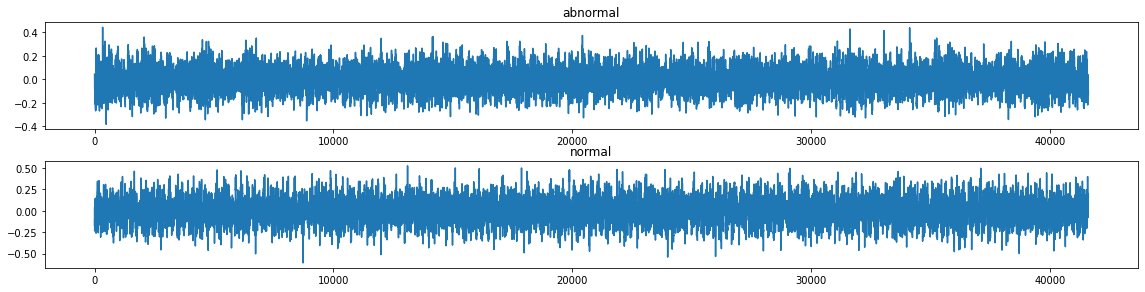

In [6]:
sampled_data_list = manager.get_raw_sample_from_each_label()

num_classes = len(sampled_data_list)
fig, axs = plt.subplots(nrows=num_classes, ncols=1, figsize=(16, 4))
plt.tight_layout()

for class_idx, sampled_audio_dict in enumerate(sampled_data_list):
    axs[class_idx].set_title(sampled_audio_dict['label'])
    if len(sampled_audio_dict['signal'].shape) == 2:
        signal_to_plot = sampled_audio_dict['signal'][-1]
    else:
        signal_to_plot = sampled_audio_dict['signal']
    axs[class_idx].plot(signal_to_plot)

## Play data

In [7]:
sampled_data_list

[{'signal': array([ 0.04449463,  0.04144287,  0.04064941, ..., -0.09338379,
         -0.13677979, -0.09570312], dtype=float32),
  'sr': 32000,
  'label': 'abnormal'},
 {'signal': array([ 0.03143311, -0.03540039, -0.06646729, ...,  0.18243408,
          0.17626953,  0.15899658], dtype=float32),
  'sr': 32000,
  'label': 'normal'}]

In [8]:
from IPython.display import Audio, display

wav_1 = sampled_data_list[0]['signal']
sr = sampled_data_list[0]['sr']
Audio(wav_1, rate=sr)

In [9]:
wav_2 = sampled_data_list[1]['signal']
sr = sampled_data_list[1]['sr']
Audio(wav_2, rate=sr)

In [10]:
# wav_3 = sampled_data_list[2]['signal']
# sr = sampled_data_list[2]['sr']
# Audio(wav_3, rate=sr)

## Get random preprocessed result from each class

In [11]:
preprocessed_list = manager.get_preprocessed_sample_from_each_label()
num_classes = len(sampled_data_list)

Classes list: ['normal' 'abnormal']


## Plot preprocessed

In [12]:
import librosa.display

/home/joohyun/.virtualenvs/lightning/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/joohyun/.virtualenvs/lightning/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


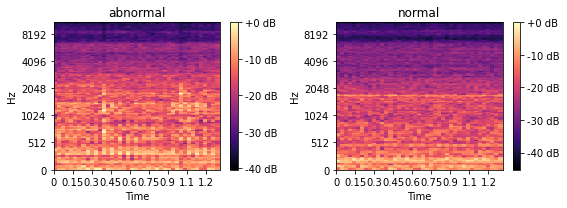

In [13]:
Y_AXIS = 'mel'
assert Y_AXIS in ['linear', 'log', 'mel']

fig, axs = plt.subplots(nrows=1, ncols=num_classes, figsize=(8, 3))

for class_idx, sampled_prep_dict in enumerate(preprocessed_list):
    axs[class_idx].set_title(sampled_prep_dict['label'])
    img = librosa.display.specshow(sampled_prep_dict['data'][0],
                                   sr=preprocessor.config['sample_rate'],
                                   hop_length=preprocessor.config['n_hops'],
                                   x_axis='time',
                                   y_axis=Y_AXIS,
                                   ax=axs[class_idx])
    fig.colorbar(img, ax=axs[class_idx], format="%+2.f dB")

plt.tight_layout()

## Label Bar Graph

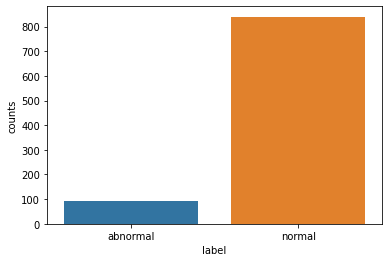

In [14]:
series_label = manager.plot_label_bar_graph()

## Duration Box Graph

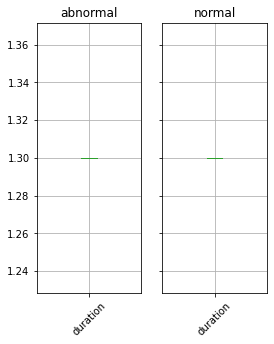

In [15]:
manager.plot_duration_box_plot()

## Features EDA

In [16]:
import statistics

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Frame raw audio
for data in sampled_data_list:
    framed = manager.signal_framing(data['signal'],
                                    fs=preprocessor.config['sample_rate'],
                                    win_len=preprocessor.config['window_length'],
                                    win_hop=preprocessor.config['hop_length'])

    data['framed'] = framed

### RMS

In [17]:
for data in sampled_data_list:
    data['rms'] = manager.feat_rms(data['framed'])

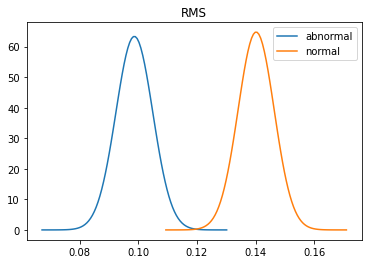

In [18]:
for data in sampled_data_list:
    mean = statistics.mean(data['rms'])
    std = statistics.stdev(data['rms'])
    x_axis = np.linspace(mean - 5 * std, mean + 5 * std, 100)
    plt.plot(x_axis, norm.pdf(x_axis, mean, std), label=data['label'])

plt.legend()
plt.title('RMS')
plt.show()

### Max

In [19]:
for data in sampled_data_list:
    data['max'] = manager.feat_max(data['framed'])

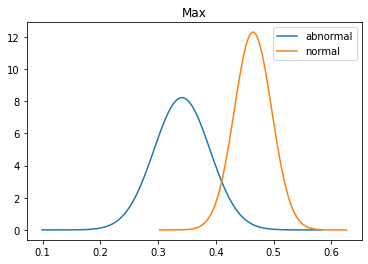

In [20]:
for data in sampled_data_list:
    mean = statistics.mean(data['max'])
    std = statistics.stdev(data['max'])
    x_axis = np.linspace(mean - 5 * std, mean + 5 * std, 100)
    plt.plot(x_axis, norm.pdf(x_axis, mean, std), label=data['label'])

plt.legend()
plt.title('Max')
plt.show()

### Variance

In [21]:
for data in sampled_data_list:
    data['var'] = manager.feat_variance(data['framed'])

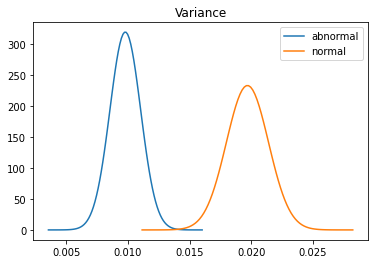

In [22]:
for data in sampled_data_list:
    mean = statistics.mean(data['var'])
    std = statistics.stdev(data['var'])
    x_axis = np.linspace(mean - 5 * std, mean + 5 * std, 100)
    plt.plot(x_axis, norm.pdf(x_axis, mean, std), label=data['label'])

plt.legend()
plt.title('Variance')
plt.show()

### Peak to Peak

In [23]:
for data in sampled_data_list:
    data['peak'] = manager.feat_peak_to_peak(data['framed'])

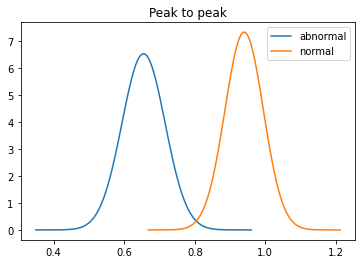

In [24]:
for data in sampled_data_list:
    mean = statistics.mean(data['peak'])
    std = statistics.stdev(data['peak'])
    x_axis = np.linspace(mean - 5 * std, mean + 5 * std, 100)
    plt.plot(x_axis, norm.pdf(x_axis, mean, std), label=data['label'])

plt.legend()
plt.title('Peak to peak')
plt.show()

### Skewness

In [25]:
for data in sampled_data_list:
    data['skew_raw'] = manager.feat_skewness(data['framed'])

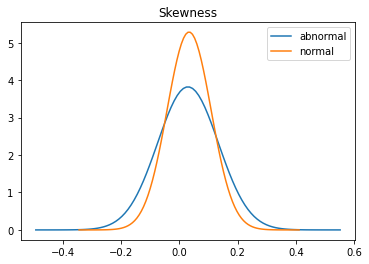

In [26]:
for data in sampled_data_list:
    mean = statistics.mean(data['skew_raw'])
    std = statistics.stdev(data['skew_raw'])
    x_axis = np.linspace(mean - 5 * std, mean + 5 * std, 100)
    plt.plot(x_axis, norm.pdf(x_axis, mean, std), label=data['label'])

plt.legend()
plt.title('Skewness')
plt.show()

### Spectral Skewness

In [27]:
for data in preprocessed_list:
    data['skew_spec'] = manager.feat_skewness(data['data'][0].T)

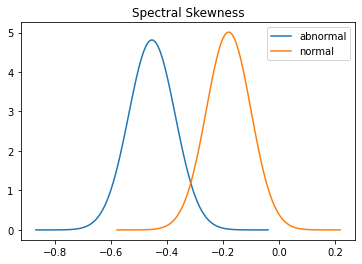

In [28]:
for data in preprocessed_list:
    mean = statistics.mean(data['skew_spec'])
    std = statistics.stdev(data['skew_spec'])
    x_axis = np.linspace(mean - 5 * std, mean + 5 * std, 100)
    plt.plot(x_axis, norm.pdf(x_axis, mean, std), label=data['label'])

plt.legend()
plt.title('Spectral Skewness')
plt.show()

### Spectral Kurtosis

In [29]:
for data in preprocessed_list:
    data['kurt'] = manager.feat_kurtosis(data['data'][0].T)

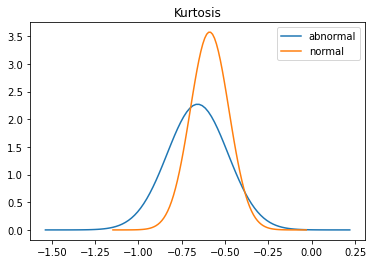

In [30]:
for data in preprocessed_list:
    mean = statistics.mean(data['kurt'])
    std = statistics.stdev(data['kurt'])
    x_axis = np.linspace(mean - 5 * std, mean + 5 * std, 100)
    plt.plot(x_axis, norm.pdf(x_axis, mean, std), label=data['label'])

plt.legend()
plt.title('Kurtosis')
plt.show()